# 통계분석

In [1]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.regressionplots import influence_plot

1.&nbsp; pop_density변수를 factor형 변수로 변환하고, pop_density별 revenues의 평균 차이가 있는지 통계분석을 시행하여 결과를 해석하시오. 만일 대립가설이 채택된다면 사후분석을 실시하고 결과를 해석하시오.

In [2]:
data_path = '/hdd/data/adp_data/bike_marketing.csv'
df = pd.read_csv(data_path, index_col = 'company_num')
df.head()

,google_adwords,facebook,twitter,marketing_total,revenues,employees,pop_density
company_num,,,,,,,
1,65.66,47.86,52.46,166,39.26,5,High
2,39.10,55.20,77.40,172,38.90,7,Medium
3,174.81,52.01,68.01,295,49.51,11,Medium
4,34.36,61.96,86.86,183,40.56,7,High
5,78.21,40.91,30.41,150,40.21,9,Low


In [3]:
df['pop_density'] = df['pop_density'].astype('category')
df['pop_density'].value_counts()

pop_density
Low       68
High      52
Medium    52
Name: count, dtype: int64

In [4]:
low = df[df['pop_density'] == 'Low']['revenues']
medium = df[df['pop_density'] == 'Medium']['revenues']
high = df[df['pop_density'] == 'High']['revenues']

anova_result = stats.f_oneway(low, medium, high)
print(anova_result)

F_onewayResult(statistic=0.609944214128908, pvalue=0.544572945313452)


In [5]:
tukey_result = pairwise_tukeyhsd(df['revenues'], df['pop_density'])
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  High    Low  -0.8642 0.7023 -3.4119 1.6836  False
  High Medium   0.2477 0.9746 -2.4646   2.96  False
   Low Medium   1.1119 0.5578 -1.4359 3.6596  False
---------------------------------------------------


2.&nbsp; google_adwords, facebook, twitter, marketing_total, employees가 revenues에 영향을 미치는지 알아보는 회귀분석을 전진 선택법을 사용하여 수행하고 결과를 해석하시오.

In [6]:
X = df[['google_adwords', 'facebook', 'twitter', 'marketing_total', 'employees']]
y = df['revenues']

def forward_selection(X, y, significance_level = 0.05):
    initial_features = []
    remaining_features = list(X.columns)
    selected_features = []

    while remaining_features:
        p_values = {}
        for feature in remaining_features:
            temp_features = selected_features + [feature]
            X_temp = sm.add_constant(X[temp_features])
            model = sm.OLS(y, X_temp).fit()
            p_values[feature] = model.pvalues[feature]
        
        min_p_value = min(p_values.values())

        if min_p_value < significance_level:
            best_feature = min(p_values, key = p_values.get)
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
    
    return selected_features

selected_features = forward_selection(X, y)
print(f'선택된 변수: ', selected_features)

선택된 변수:  ['marketing_total', 'facebook', 'google_adwords', 'employees', 'twitter']


In [7]:
X_final = sm.add_constant(X[selected_features])
final_model = sm.OLS(y, X_final).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:               revenues   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     228.9
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.57e-72
Time:                        16:08:57   Log-Likelihood:                -369.26
No. Observations:                 172   AIC:                             750.5
Df Residuals:                     166   BIC:                             769.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              28.4433      0.596     

3.&nbsp; 전진선택법을 사용해 변수를 선택한 후 새롭게 생성한 회귀모형에 대한 잔차분석을 수행하고 결과를 해석하시오.

Shapiro-Wilk Test: W = 0.987, p = 0.099


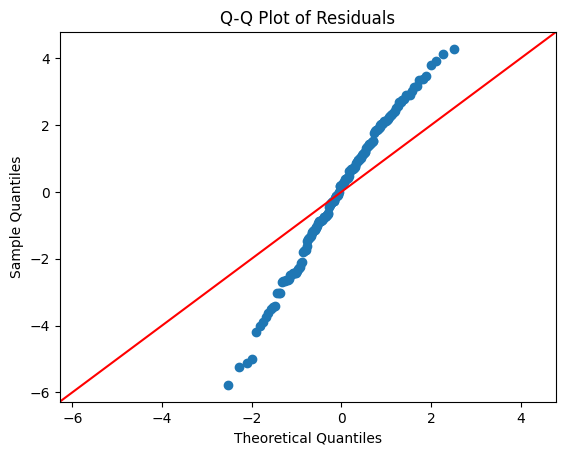

In [8]:
residuals = final_model.resid
fitted_values = final_model.fittedvalues

residuals_df = pd.DataFrame({'Fitted': fitted_values, 'Residuals': residuals})

sm.qqplot(residuals, line = '45')
plt.title('Q-Q Plot of Residuals')

stat, p = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test: W = {stat:.3f}, p = {p:.3f}')

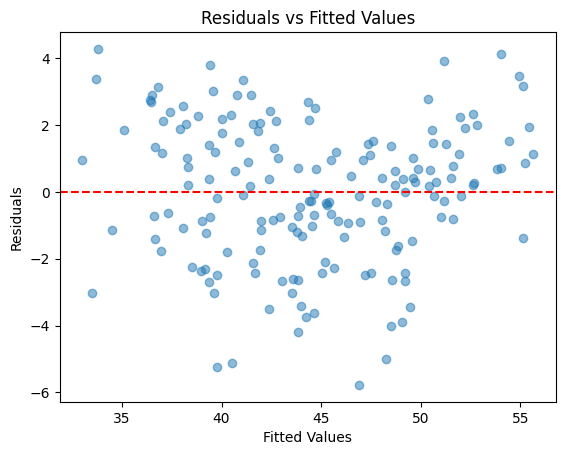

In [9]:
plt.scatter(fitted_values, residuals, alpha = 0.5)
plt.axhline(0, color = 'red', linestyle = '--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

In [10]:
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw_stat:.3f}')

Durbin-Watson Statistic: 2.111


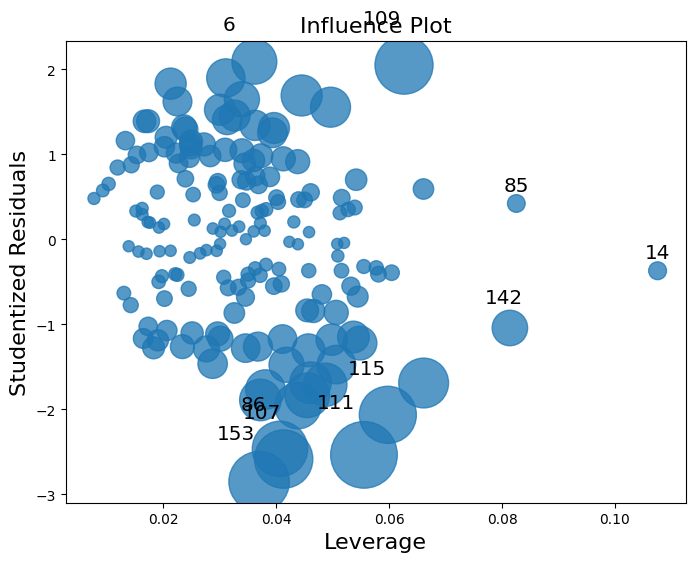

In [11]:
fig, ax = plt.subplots(figsize = (8, 6))
influence_plot(final_model, ax = ax)
plt.show()